# Datathon 2024
### Team: Sleepy Racoons (Don't wake me up!)
### Team members: Yuqi Chen, Zikang Chen, Yuxuan Xue, Xi Yu
### Track: Neurotech

# Part 0: Setup

In [12]:
!pip install umap-learn

In [339]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import umap
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv1D, MaxPooling1D, Flatten,
                                     LSTM, Dropout, Reshape, GlobalAveragePooling1D,
                                     Input, Multiply)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Reshape, Permute,
                                     TimeDistributed, Layer)
import tensorflow.keras.backend as K

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
eval_a_X = np.load('/content/drive/My Drive/Datathon 2024/Neurotech@Rice Datathon Challenge/Evaluation [NEW]/eval_a_NEW_X.npy')
eval_b_X = np.load('/content/drive/My Drive/Datathon 2024/Neurotech@Rice Datathon Challenge/Evaluation [NEW]/eval_b_NEW_X.npy')

In [16]:
display(eval_a_X.shape)
display(eval_b_X.shape)

(1300, 6, 3000)

(1300, 6, 3000)

# Part1: Try to explore the nature of the datasets p00_n1_X, p00_n1_y

In [151]:
p00_n1_X = np.load('/content/drive/My Drive/Datathon 2024/Neurotech@Rice Datathon Challenge/Training [NEW]/p00_n1_NEW_X.npy')
p00_n1_y = np.load('/content/drive/My Drive/Datathon 2024/Neurotech@Rice Datathon Challenge/Training [NEW]/p00_n1_NEW_y.npy')

In [152]:
X = p00_n1_X.copy()
y = p00_n1_y.copy()

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (2650, 6, 3000)
Shape of y: (2650,)


`The six plots below represent individual channels of the dataset for p00_n1_X, offering a visual assessment of the data's characteristics. Channels 1 to 3 exhibit sharp and rapid fluctuations in amplitude, indicating a high level of variability within these signals. In contrast, Channels 4 to 6 display smoother waveforms, suggesting a more gradual change in amplitude over the samples. This comparative analysis of the channels helps to understand the diverse nature of the dataset`

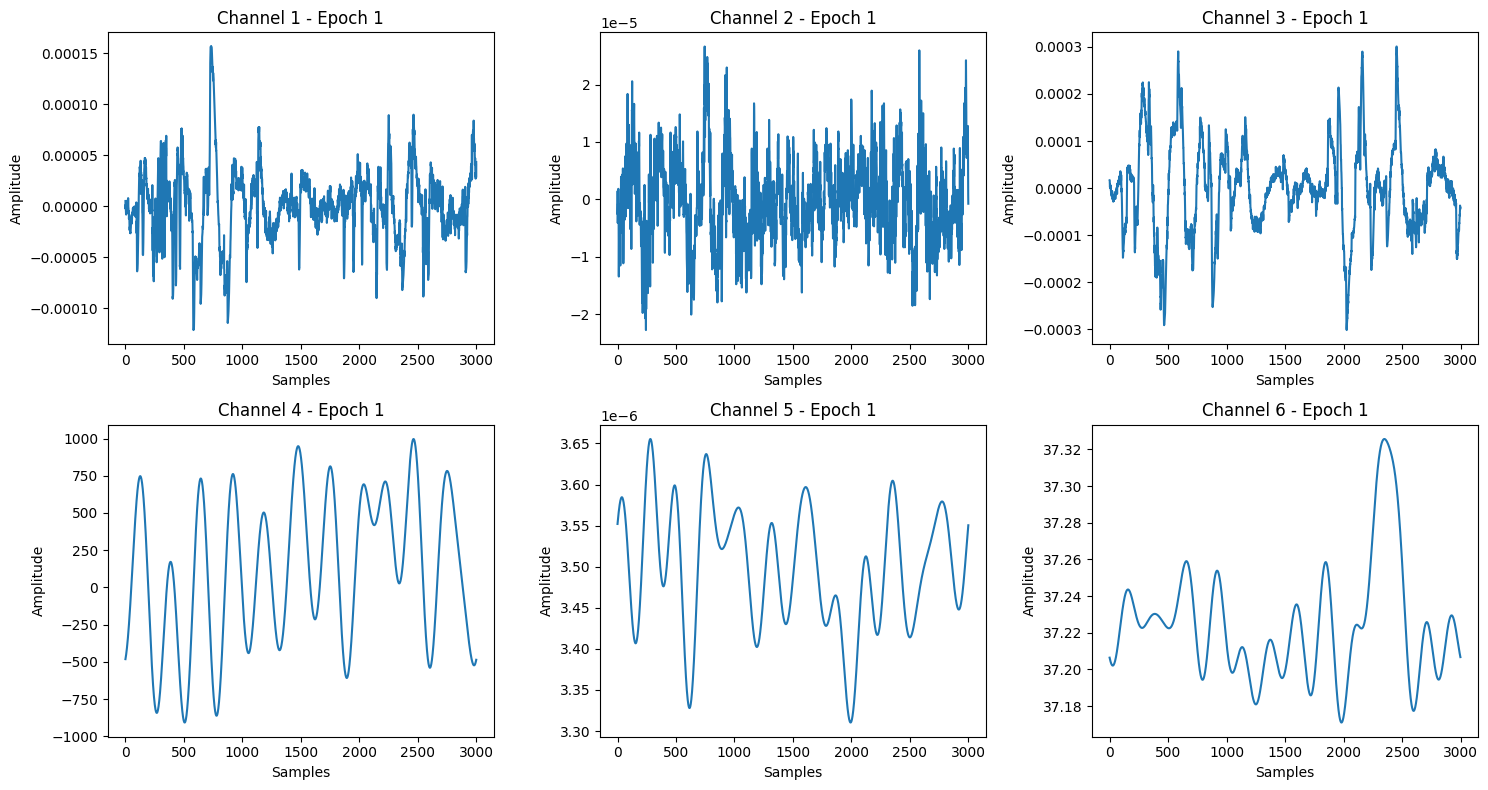

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Loop through the channels and plot the first epoch of each channel
for i in range(6):
    row = i // 3
    col = i % 3

    axs[row, col].plot(X[0, i, :])
    axs[row, col].set_title(f"Channel {i+1} - Epoch 1")
    axs[row, col].set_xlabel("Samples")
    axs[row, col].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

`Upon visualizing the p00_n1_y dataset through a distribution plot, we observed a notable discrepancy in the frequency of sleep stages. The plot revealed that Stage 1 is disproportionately represented with a frequency much higher than the others. This preliminary exploration is critical for understanding the underlying structure of our dataset and informs our approach to further data preprocessing.`

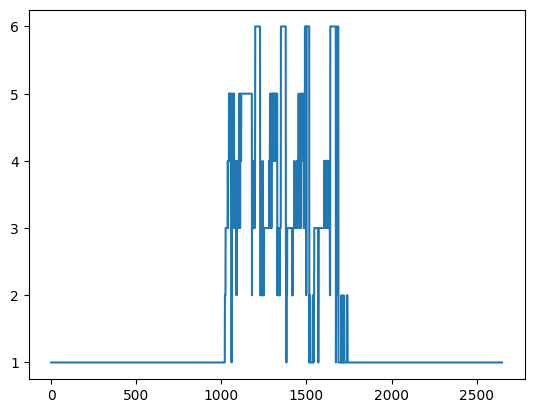

In [20]:
plt.plot(p00_n1_y)

In [153]:
class_distribution = Counter(y)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({1.0: 1997, 3.0: 250, 6.0: 125, 5.0: 119, 4.0: 101, 2.0: 58})


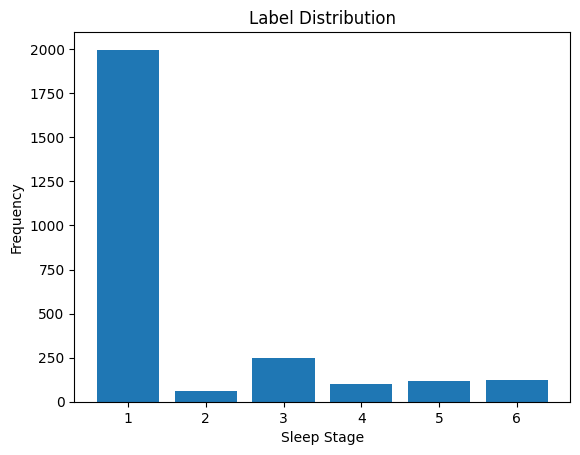

In [154]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.title("Label Distribution")
plt.xlabel("Sleep Stage")
plt.ylabel("Frequency")
plt.show()

`The bar chart above illustrates a significant imbalance in the dataset's label distribution, particularly with an overwhelming predominance of Stage 1 sleep. To address this disparity and create a more uniform distribution across all sleep stages, we plan to implement a downsampling strategy on the original dataset in the subsequent processing steps. `

# Part 2: Downsampling

`Upon observing the disproportionately high occurrence of Stage 1 within our dataset, we employed a downsampling strategy specifically aimed at reducing the prevalence of this stage. This intentional rebalancing makes the distribution across various sleep stages more uniform, thereby enhancing the potential for our analytical models to perform with greater accuracy and less bias toward the previously overrepresented Stage 1.`

In [155]:
class_distribution = Counter(y)

# Find the count of the next most frequent class
most_common_classes = class_distribution.most_common()
next_most_common_count = most_common_classes[1][1]

# Number of samples to keep from class '1'
n_samples_to_keep = next_most_common_count

In [156]:
# Indices of class '1' and other classes
indices_class_1 = np.where(y == 1)[0]
indices_other_classes = np.where(y != 1)[0]

# Randomly select samples from class '1'
np.random.shuffle(indices_class_1)
indices_class_1_downsampled = indices_class_1[:n_samples_to_keep]

# Combine and shuffle indices
downsampled_indices = np.concatenate([indices_class_1_downsampled, indices_other_classes])
np.random.shuffle(downsampled_indices)

# Create the downsampled dataset
X_downsampled = X[downsampled_indices]
y_downsampled = y[downsampled_indices]

# Checking the new distribution
new_class_distribution = Counter(y_downsampled)
print("Class Distribution after under-sampling:", new_class_distribution)

Class Distribution after under-sampling: Counter({3.0: 250, 1.0: 250, 6.0: 125, 5.0: 119, 4.0: 101, 2.0: 58})


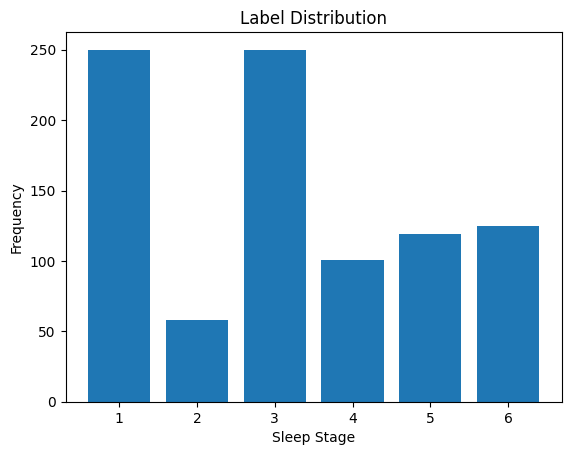

In [157]:
unique_downsampled, counts_downsampled = np.unique(y_downsampled, return_counts=True)
plt.bar(unique_downsampled, counts_downsampled)
plt.title("Label Distribution")
plt.xlabel("Sleep Stage")
plt.ylabel("Frequency")
plt.show()

In [26]:
X_downsampled.shape

(903, 6, 3000)

`The bar chart above displays the frequency of occurrences for different sleep stages after applying a downsampling technique to the dataset. Notably, there has been a significant reduction in the frequency of Stage 1 sleep. Now we can further process our data.`

# Part 3: Feature Selection

`In this part, we tried various methods (UMAP, PCA and t-SNE) to explore which channel is more informative.`

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} over

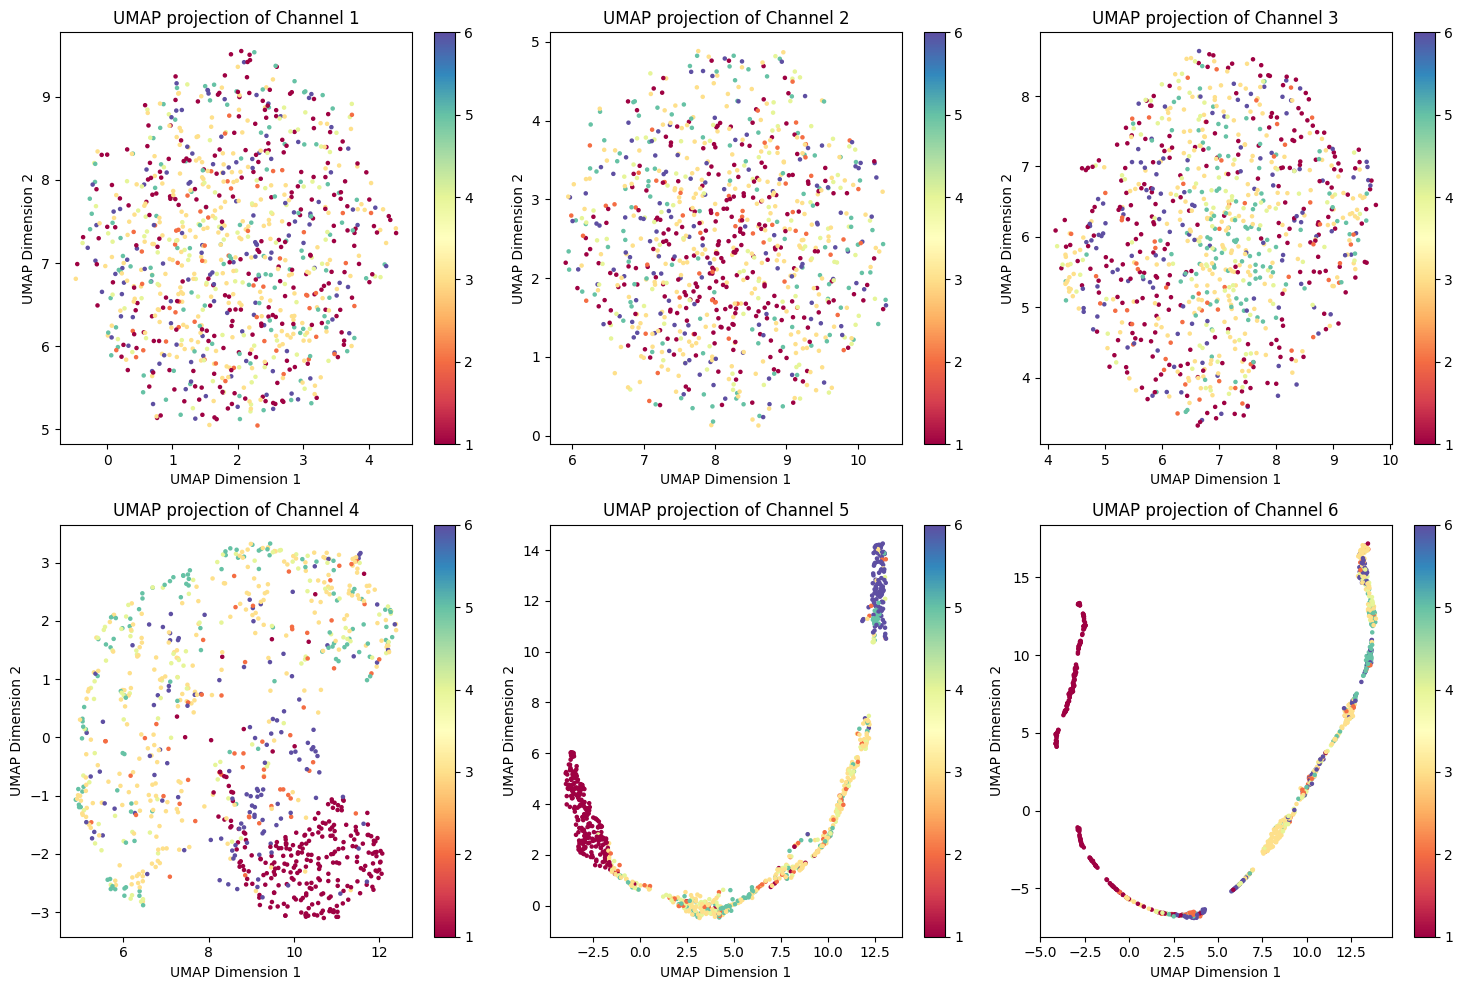

In [27]:
# Set up UMAP
reducer = umap.UMAP(random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Iterate over each channel
for i in range(6):
    row = i // 3
    col = i % 3

    # Flatten the data for the current channel across all epochs
    X_channel = X_downsampled[:, i, :].reshape(-1, 3000)

    # Normalize the data for the current channel
    scaler = StandardScaler()
    X_channel_normalized = scaler.fit_transform(X_channel)

    # Perform UMAP reduction on the normalized data
    embedding = reducer.fit_transform(X_channel_normalized)

    # Plot the result
    ax = axes[row, col]
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    ax.set_title(f'UMAP projection of Channel {i+1}', fontsize=12)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    fig.colorbar(scatter, ax=ax)


plt.tight_layout()
plt.show()

`We first perform UMAP and plot the result. The distribution of points in each plot shows how the data is clustered or spread out in two-dimensional space after the UMAP transformation. Some plots show a tight clustering (like Channel 4, 5, and 6), while others are more diffusely distributed (like Channels 1, 2, and 3).`

`Channels 5 and 6 demonstrate very clear patterns where points seem to follow a curved trajectory. This might suggest some underlying structure or relationship between the data points that UMAP is revealing.`

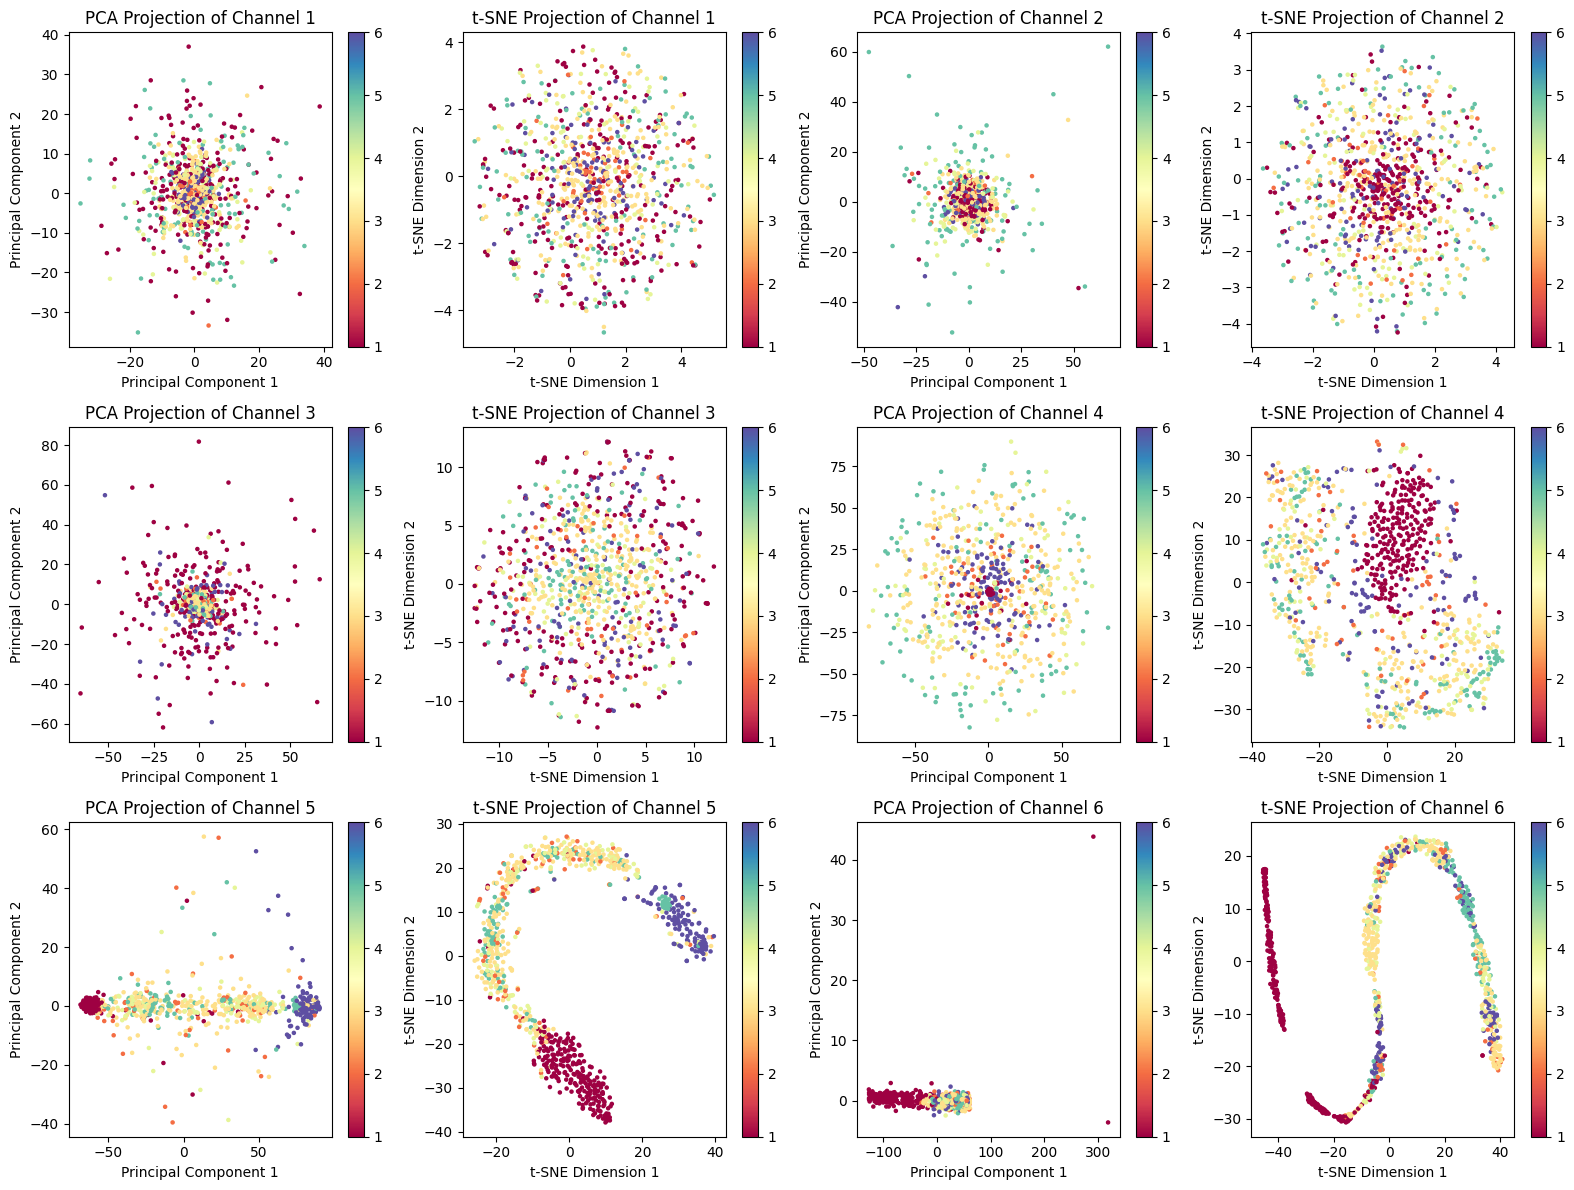

In [28]:
# Set up PCA and t-SNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)


fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Iterate over each channel
for i in range(6):
    row = i // 2
    col = i % 2

    # Flatten the data for the current channel across all epochs
    X_channel = X_downsampled[:, i, :].reshape(-1, 3000)

    # Normalize the data for the current channel
    scaler = StandardScaler()
    X_channel_normalized = scaler.fit_transform(X_channel)

    # Perform PCA
    pca_result = pca.fit_transform(X_channel_normalized)

    # Plot PCA result
    ax1 = axes[row, col * 2]
    scatter1 = ax1.scatter(pca_result[:, 0], pca_result[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    ax1.set_title(f'PCA Projection of Channel {i+1}', fontsize=12)
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    fig.colorbar(scatter1, ax=ax1)

    # Perform t-SNE
    tsne_result = tsne.fit_transform(X_channel_normalized)

    # Plot t-SNE result
    ax2 = axes[row, col * 2 + 1]
    scatter2 = ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    ax2.set_title(f't-SNE Projection of Channel {i+1}', fontsize=12)
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    fig.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

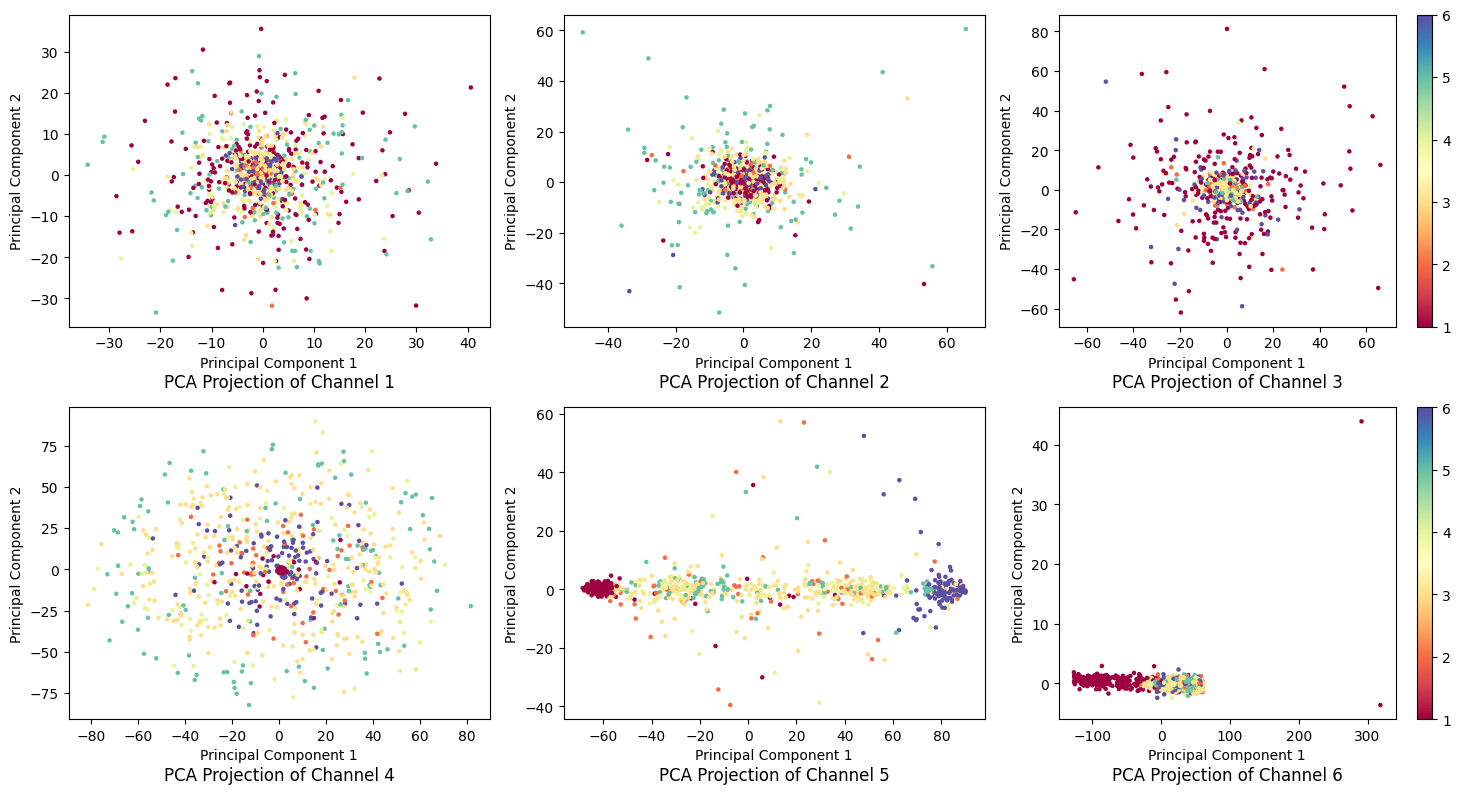

In [29]:
# Set up PCA
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Create 2 rows and 3 columns of plots

# Iterate over each channel
for i in range(6):
    row = i // 3
    col = i % 3

    # Flatten the data for the current channel across all epochs
    X_channel = X_downsampled[:, i, :].reshape(-1, 3000)

    # Normalize the data for the current channel
    scaler = StandardScaler()
    X_channel_normalized = scaler.fit_transform(X_channel)

    # Perform PCA
    pca_result = pca.fit_transform(X_channel_normalized)

    # Plot PCA result
    ax = axes[row, col]
    scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    # Place the title at the bottom of the plot
    ax.text(0.5, -0.15, f'PCA Projection of Channel {i+1}', fontsize=12, ha='center', va='top', transform=ax.transAxes)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    # Only create colorbars for the rightmost plots to avoid clutter
    if col == 2:
        fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()



`We first utilized PCA.
The PCA plots depict the dimensional reduction of six channels from a multi-dimensional dataset into two principal components. The spread and clustering of data points vary across channels, with Channels 1, 3, and 4 showing central clustering, Channel 2 a wide spread along the primary axis, Channel 5 displaying a linear pattern, and Channel 6 having a tight cluster with outliers. Color variation indicates distinct groups within the data, hinting at the potential for classification or further analysis based on these patterns.`

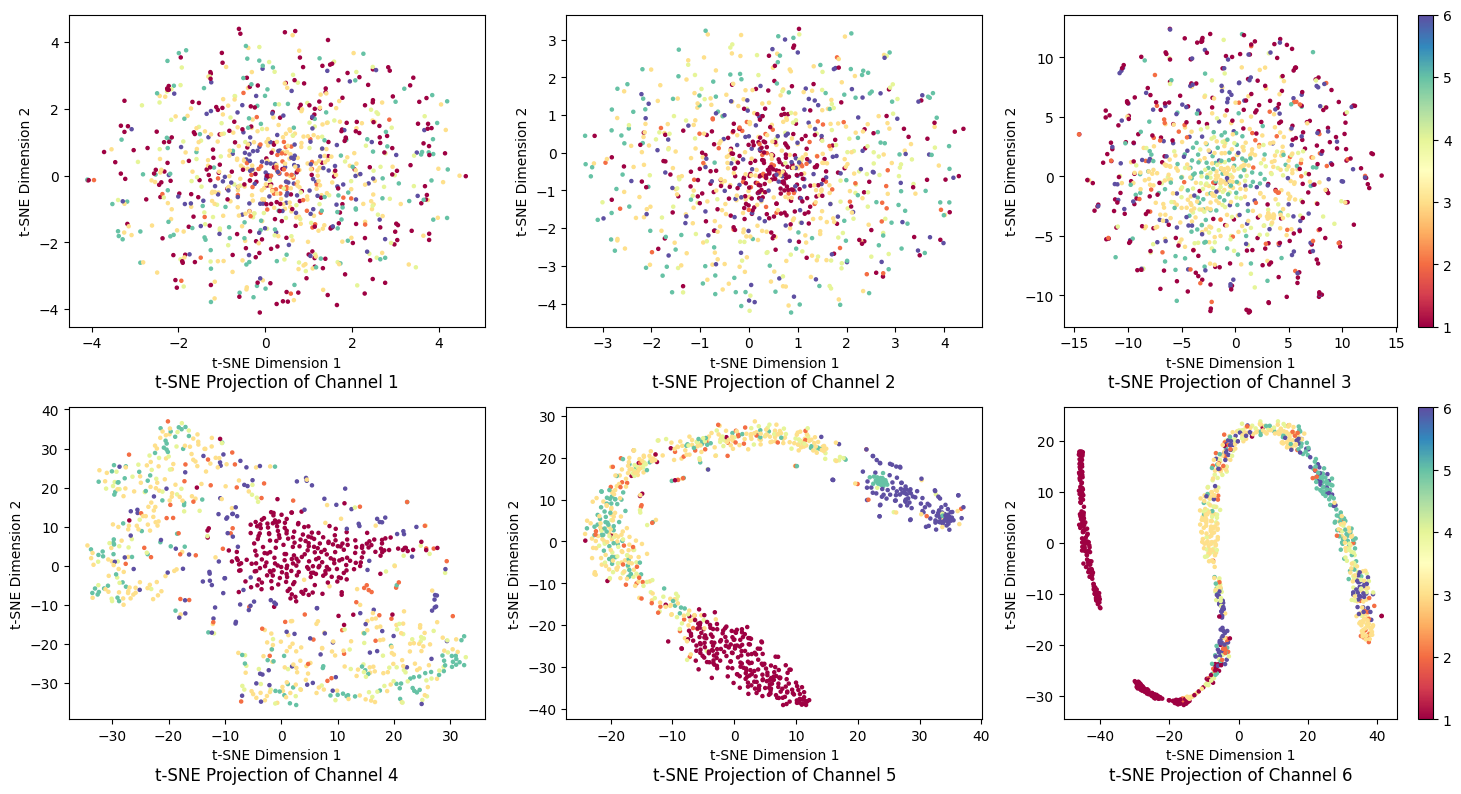

In [30]:
# Set up t-SNE
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Create 2 rows and 3 columns of plots

# Iterate over each channel
for i in range(6):
    row = i // 3
    col = i % 3

    # Flatten the data for the current channel across all epochs
    X_channel = X_downsampled[:, i, :].reshape(-1, 3000)

    # Normalize the data for the current channel
    scaler = StandardScaler()
    X_channel_normalized = scaler.fit_transform(X_channel)

    # Perform t-SNE
    tsne_result = tsne.fit_transform(X_channel_normalized)

    # Plot t-SNE result
    ax = axes[row, col]
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    # Place the title at the bottom of the plot
    ax.text(0.5, -0.15, f't-SNE Projection of Channel {i+1}', fontsize=12, ha='center', va='top', transform=ax.transAxes)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    # Only create colorbars for the rightmost plots to avoid clutter
    if col == 2:
        fig.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

`We then utlized t-SNE to perform dimensional reduction. The t-SNE plots visualize high-dimensional data from six channels reduced to two dimensions, revealing varied patterns and potential clusters. Channels 1 and 2 display a diffuse spread of data points, lacking distinct clusters. Channel 3 shows a gradient, suggesting some continuous feature variation. Channel 4 presents a central dense cluster with sparse outliers. Notably, Channels 5 and 6 exhibit more defined structures, with Channel 5 displaying a clear separation between two groups and Channel 6 showing a loop-like distribution, indicative of a systematic progression in the data. The color gradient across plots implies varying classes or states within the channels.`

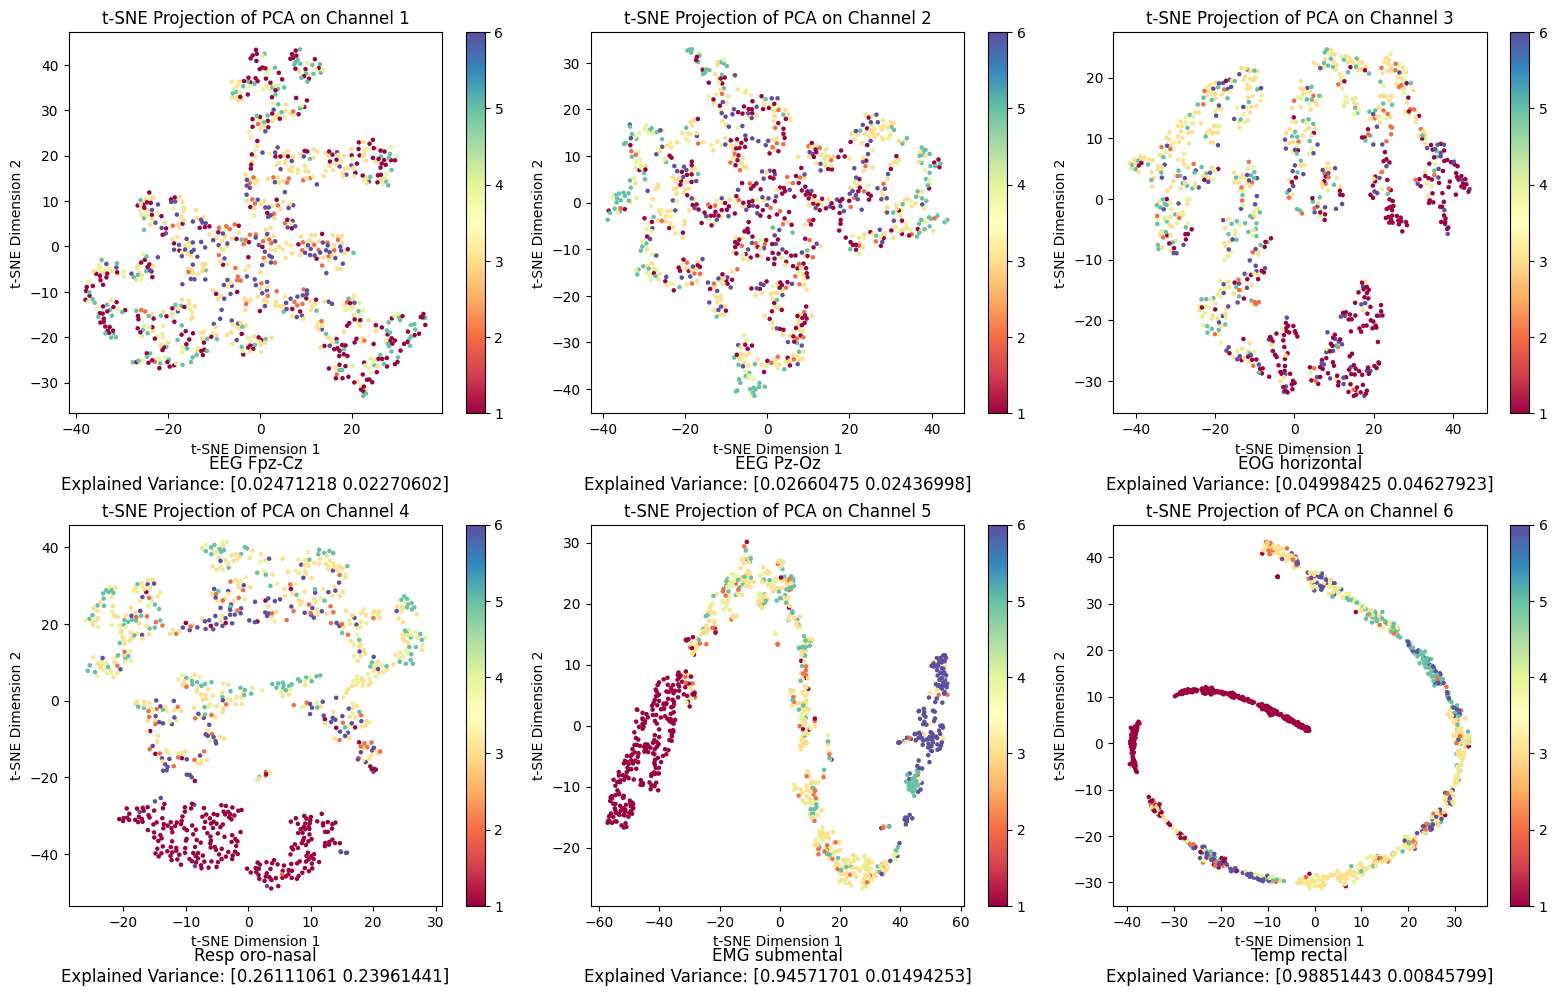

In [338]:
# Set up PCA and t-SNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

# Define channel names
channel_names = [
    "EEG Fpz-Cz",
    "EEG Pz-Oz",
    "EOG horizontal",
    "Resp oro-nasal",
    "EMG submental",
    "Temp rectal"
]

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Initialize an array to store cumulative explained variance for each channel
cumulative_variance = np.zeros(6)

# Iterate over each channel
for i in range(6):
    # Calculate the row and column indices for the subplots
    row = i // 3
    col = i % 3

    # Flatten the data for the current channel across all epochs
    X_channel = X_downsampled[:, i, :].reshape(-1, 3000)

    # Normalize the data for the current channel
    scaler = StandardScaler()
    X_channel_normalized = scaler.fit_transform(X_channel)

    # Perform PCA
    pca_result = pca.fit_transform(X_channel_normalized)

    # Calculate the explained variance ratio
    explained_variance = pca.explained_variance_ratio_

    # Calculate cumulative explained variance
    cumulative_variance[i] = np.sum(explained_variance)

    # Perform t-SNE on PCA result
    tsne_result = tsne.fit_transform(pca_result)

    # Plot t-SNE result in the current subplot
    ax = axes[row, col]
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_downsampled, cmap='Spectral', s=5)
    ax.set_title(f't-SNE Projection of PCA on Channel {i+1}', fontsize=12)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

    # Add channel name annotation and explained variance ratio
    ax.text(0.5, -0.2, f'{channel_names[i]}\nExplained Variance: {explained_variance}', size=12, ha='center', transform=ax.transAxes)

    fig.colorbar(scatter, ax=ax)


plt.tight_layout()
plt.show()

In [174]:
print(cumulative_variance)

[0.04744347 0.05085027 0.09626327 0.50072501 0.96065954 0.99697242]


`Lastly, we performed PCA first then performed t-SNE. The plots show a two-stage dimensionality reduction on six data channels, using PCA for initial variance preservation followed by t-SNE to visualize clusters. Some plots show a tight clustering (like Channel 4, 5, and 6), while others are more diffusely distributed (like Channels 1, 2, and 3).`

`Channels 1 to 3 show mixed data points, Channel 4 has a central cluster, Channel 5 displays distinct groupings, and Channel 6 forms a curved pattern, suggesting complex structures and potential relationships within the data. The color gradient likely denotes different classes or categories.`

# Part 4: CNN + LSTM + Attention based on channel_weights

In [289]:
# List of training file names
pre_path = '/content/drive/My Drive/Datathon 2024/Neurotech@Rice Datathon Challenge/Training [NEW]'

train_files = []
label_files = []

# Loop through each file in the directory
count = 0
for file_name in os.listdir(pre_path):
    if file_name.endswith('_X.npy'):
      y_file_name = file_name.replace('_X.npy', '_y.npy')
      train_files.append(pre_path + '/' + file_name)
      label_files.append(pre_path + '/' + y_file_name)
      count += 1
    if count == 12:
      break

In [293]:
x_data = np.load(train_files[0])
y_data = np.load(label_files[0])

print(x_data.shape)
print(y_data.shape)

(2650, 6, 3000)
(2650,)


In [322]:
# Reshape for standardization (flatten the first two dimensions)
X_reshaped = X_downsampled.reshape(-1, X_downsampled.shape[-1])

# Standardize
mean = X_reshaped.mean(axis=0)
std = X_reshaped.std(axis=0)
X_standardized = (X_reshaped - mean) / std

# Reshape back to original shape
X_scaled_reshaped = X_standardized.reshape(X_downsampled.shape)

In [323]:
# This treats each of the 3000 samples as 30 subsequences of 100 samples each
X_reshaped = X_scaled_reshaped.reshape((X_scaled_reshaped.shape[0], X_scaled_reshaped.shape[1], -1, 30))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_downsampled, test_size=0.2, random_state=42)

In [324]:
# Standardize the cumulative explained variance values to have a mean of 1
channel_weights = cumulative_variance / np.mean(cumulative_variance)

# Display channel_weights
print("Channel Weights:", channel_weights)

Channel Weights: [0.10730118 0.11500623 0.21771517 1.13247173 2.17268908 2.25481661]


In [326]:
class CustomAttentionLayer(Layer):
    def __init__(self, channel_weights=None, **kwargs):
        super(CustomAttentionLayer, self).__init__(**kwargs)
        self.channel_weights = channel_weights

    def build(self, input_shape):
        # Assuming channel_weights is a list of weights for each channel
        if self.channel_weights is None:
            self.channel_weights = [1.0] * input_shape[-1]

        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 trainable=True)
        super(CustomAttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W))
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [314]:
model = Sequential([
    # CNN Layer
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), kernel_regularizer=l2(0.01), input_shape=(6, 100, 30, 1)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Flatten()),

    # LSTM Layers
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=True),
    Dropout(0.5),

    # Attention Layer
    CustomAttentionLayer(channel_weights=channel_weights),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
12/12 [==============================] - 28s 2s/step - loss: 1.8818 - accuracy: 0.2216 - val_loss: 1.7678 - val_accuracy: 0.2873
Epoch 2/10
12/12 [==============================] - 20s 2s/step - loss: 1.7799 - accuracy: 0.2535 - val_loss: 1.7171 - val_accuracy: 0.2652
Epoch 3/10
12/12 [==============================] - 20s 2s/step - loss: 1.7493 - accuracy: 0.2673 - val_loss: 1.7087 - val_accuracy: 0.2873
Epoch 4/10
12/12 [==============================] - 36s 3s/step - loss: 1.7406 - accuracy: 0.2729 - val_loss: 1.6922 - val_accuracy: 0.2873
Epoch 5/10
12/12 [==============================] - 23s 2s/step - loss: 1.7307 - accuracy: 0.2825 - val_loss: 1.6817 - val_accuracy: 0.3646
Epoch 6/10
12/12 [==============================] - 20s 2s/step - loss: 1.6989 - accuracy: 0.2978 - val_loss: 1.6344 - val_accuracy: 0.5028
Epoch 7/10
12/12 [==============================] - 23s 2s/step - loss: 1.6771 - accuracy: 0.3601 - val_loss: 1.6280 - val_accuracy: 0.4807
Epoch 8/10
12/12 [==

In [328]:
remove_samples = (eval_a_X.shape[0] - 903) // 2
eval_a_X = eval_a_X[remove_samples:remove_samples + 903, :, :]

In [329]:
# Flatten the first two dimensions of eval_a_X
eval_a_X_reshaped = eval_a_X.reshape(-1, eval_a_X.shape[-1])

# Standardize using the mean and std of the training data
eval_a_X_standardized = (eval_a_X_reshaped - mean) / std

# Reshape back to the original shape of eval_a_X
eval_a_X_standardized_reshaped = eval_a_X_standardized.reshape(eval_a_X.shape)

# Predict using the model
eval_a_X_for_model = eval_a_X_standardized_reshaped.reshape((eval_a_X_standardized_reshaped.shape[0], eval_a_X_standardized_reshaped.shape[1], -1, 30))

# predictions = model.predict(eval_a_X_for_model)
# predicted_stages = np.argmax(predictions, axis=1)

In [330]:
predictions = model.predict(eval_a_X_for_model)

29/29 [==============================] - 9s 305ms/step


In [332]:
predicted_stages = np.argmax(predictions, axis=1)

In [336]:
remove_samples = (eval_b_X.shape[0] - 903) // 2
eval_b_X = eval_b_X[remove_samples:remove_samples + 903, :, :]

# Flatten the first two dimensions of eval_a_X
eval_b_X_reshaped = eval_b_X.reshape(-1, eval_b_X.shape[-1])

# Standardize using the mean and std of the training data
eval_b_X_standardized = (eval_b_X_reshaped - mean) / std

# Reshape back to the original shape of eval_a_X
eval_b_X_standardized_reshaped = eval_b_X_standardized.reshape(eval_b_X.shape)

# Predict using the model
eval_b_X_for_model = eval_b_X_standardized_reshaped.reshape((eval_b_X_standardized_reshaped.shape[0], eval_b_X_standardized_reshaped.shape[1], -1, 30))

predictions = model.predict(eval_b_X_for_model)
predicted_stages = np.argmax(predictions, axis=1)

29/29 [==============================] - 8s 278ms/step
